gofasta vs amanual mutation calling

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from Bio import SeqIO
import os
import re

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", None)

In [4]:
sc2_mm_dir = "/home/yutianc/bjorn_rep/output/SC2/escape_all"
hu1_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_Hu1/'
ba1_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.1_escape/'
ba2_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.2_escape/'


pb2_old_dir = '/home/yutianc/bjorn_rep/data/PB2-DMS/'
pb2_gf_dir = '/home/yutianc/bjorn_rep/output/PB2/gf_PP/'
pb2_mm_dir = '/home/yutianc/bjorn_rep/output/PB2/mm/'
cy_gf_dir = '/home/yutianc/bjorn_rep/output/PB2/gf_CY/'
cy_mm_dir = '/home/yutianc/bjorn_rep/output/PB2/mm/'

sc2_escape_dir = '/home/yutianc/bjorn_rep/output/SC2/escape_all/'
ba275_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.2.75/'
ba45_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_BA.4_BA.5/'
xbb_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_XBB.1.5/'
jn1_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_JN.1/'
kp2_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_KP.2/'
kp3_gf_dir = '/home/yutianc/bjorn_rep/output/SC2/gf_KP.3/'


In [5]:
ambiguous_nuc = ['R', 'Y', 'W', 'S', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

In [6]:
def process(path, common_set):
    df = pd.read_csv(path, sep="\t")
    if common_set:
        df_filtered = df.copy()
        df_filtered["sra"] = df_filtered["sra"].apply(lambda x: x.split('/')[2] if len(x.split('/')) == 4 else x)
        df_filtered = df_filtered.loc[(df_filtered["sra"].isin(common_set)), :]

        return df, df_filtered
    else:
        return df, None

In [7]:
def corr_plt_nuc(standard_df, manual_df, title):
    standard, manual = standard_df.copy(), manual_df.copy()
    standard_grp = (
        standard[~standard["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual_grp = (
        manual[~manual["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged['pos_count_manual'], merged['pos_count_standard'], color='lightblue')
    minv = min(merged['pos_count_manual'])
    maxv = max(merged['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"Nuc Comparision - {title}")
    plt.tight_layout()
    plt.show()

    pos_mismatch = merged[merged['pos_count_standard'] != merged['pos_count_manual']]
    pos_mismatch = pos_mismatch.copy()
    pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
    pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)

    return pos_mismatch

In [8]:
def corr_plt_aa(standard_df, manual_df, title):
    standard, manual = standard_df.copy(), manual_df.copy()
    standard_grp = (
        standard[(~standard["alt"].str.upper().isin(ambiguous_nuc)) & ((~standard["GFF_FEATURE"].isna()))]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual.loc[(manual["ref_aa"] == "X") | (manual["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = None
    manual_grp = (
        manual[(~manual["alt"].str.upper().isin(ambiguous_nuc)) & ((~manual["GFF_FEATURE"].isna()))]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged['pos_count_manual'], merged['pos_count_standard'], color='lightblue')
    minv = min(merged['pos_count_manual'])
    maxv = max(merged['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"AA Comparision {title}")
    plt.tight_layout()
    plt.show()

    pos_mismatch = merged[merged['pos_count_standard'] != merged['pos_count_manual']]
    pos_mismatch = pos_mismatch.copy()
    pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
    pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)
    
    return pos_mismatch


In [9]:
def get_common_seqs(fa1, fa2):
    seq1 = {(rec.id).split('/')[2] if len(rec.id.split('/')) == 4 else rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa1, "fasta")}
    seq2 = {(rec.id).split('/')[2] if len(rec.id.split('/')) == 4 else rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa2, "fasta")}
    common_ids = set(seq1.keys()) & set(seq2.keys())
    
    return [i for i in common_ids if seq1[i] == seq2[i]]

In [10]:
# A is standard mutation, B is manual mutation
def compare(dir_a, dir_b, id):
    print(id)
    
    common_set = get_common_seqs(os.path.join(dir_a, "alignment.fasta"), os.path.join(dir_b, "alignment.fasta"))
    mut_a, mut_a_filtered = process(os.path.join(dir_a, "mutations.tsv"), common_set)
    mut_b, mut_b_filtered = process(os.path.join(dir_b, "mutations.tsv"), common_set)
    mut_b_filtered = mut_b_filtered[mut_b_filtered['region'] == id]

    print(round(len(mut_a_filtered)/len(mut_a), 2)*100, "% identical in alignment.")
    pos_mismatch = corr_plt_nuc(mut_a_filtered, mut_b_filtered, id)
    print(pos_mismatch)
    pos_mismatch = corr_plt_aa(mut_a_filtered, mut_b_filtered, id)
    print(pos_mismatch)

    tmp1 = (mut_a_filtered[~mut_a_filtered["alt"].isin(ambiguous_nuc)]
            .drop(columns=["ref_codon", "alt_codon"])
            .sort_values(by=["sra", "pos", "GFF_FEATURE"])
            .reset_index(drop=True)
    )

    mut_b_filtered = mut_b_filtered.drop(columns=["ref_codon", "alt_codon"])

    tmp2_a = mut_b_filtered[mut_b_filtered["alt_aa"] == "X"]
    tmp2_b = mut_b_filtered[mut_b_filtered["alt_aa"] != "X"]

    tmp2_a.loc[(tmp2_a["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = None    
    tmp2_a = tmp2_a.drop_duplicates()
    tmp2_a = tmp2_a[~tmp2_a["alt"].isin(ambiguous_nuc)]

    tmp2_b = tmp2_b[~tmp2_b["alt"].isin(ambiguous_nuc)]

    tmp2 = pd.concat([tmp2_a, tmp2_b], ignore_index=True)
    tmp2 = tmp2.sort_values(by=["sra", "pos", "GFF_FEATURE"]).reset_index(drop=True)

    print(len(tmp1))
    print(len(tmp2))    

    try:
        tmp1.compare(tmp2, keep_equal=True)
    except:
        print("Somthing wrong...")

    return mut_a_filtered, mut_b_filtered, tmp1, tmp2






## Hu1, BA.1, and BA.2


NC_045512.2
100.0 % identical in alignment.


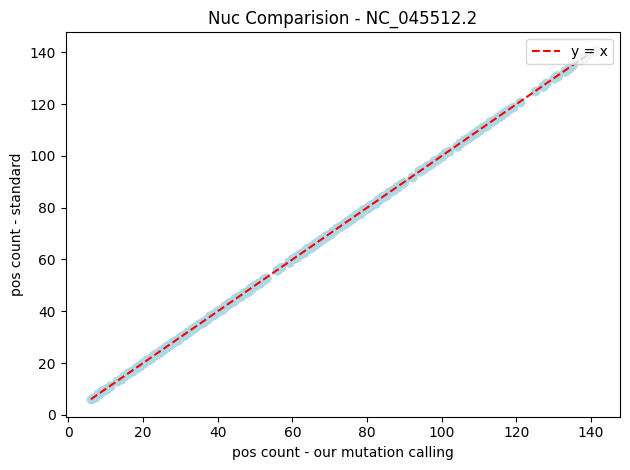

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


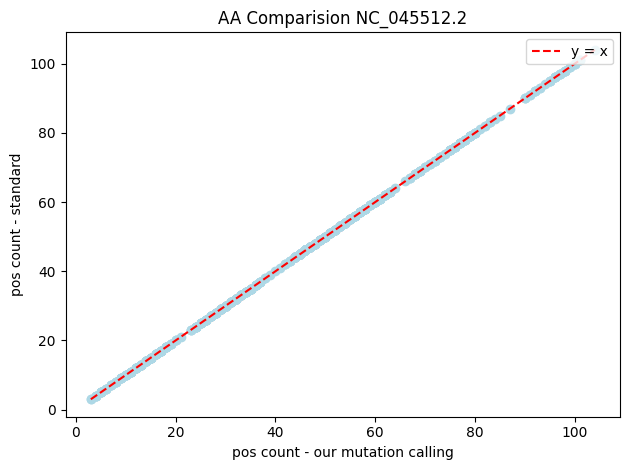

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
68031
68031


In [11]:
mut_a, mut_b, tmp1, tmp2 = compare(hu1_gf_dir, sc2_mm_dir, "NC_045512.2")

NC_045512.2_escape_BA.1_rbd
100.0 % identical in alignment.


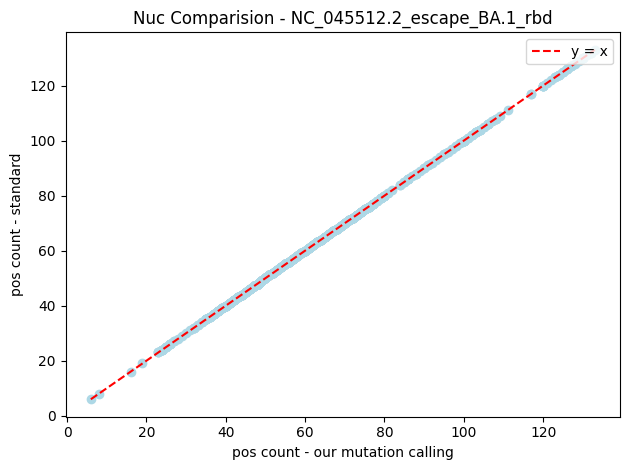

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


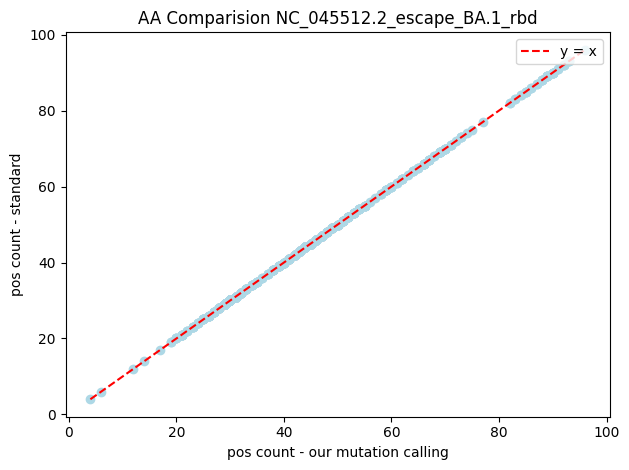

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
67910
67910


In [12]:
mut_a, mut_b, tmp1, tmp2 = compare(ba1_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.1_rbd")

NC_045512.2_escape_BA.2_rbd
100.0 % identical in alignment.


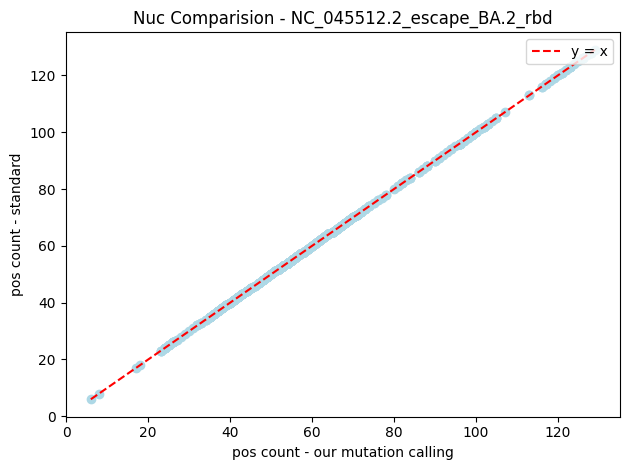

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


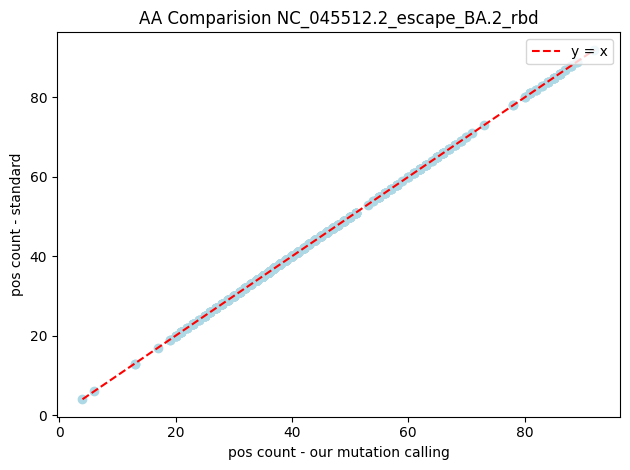

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
67348
67348


In [13]:
mut_a, mut_b, tmp1, tmp2 = compare(ba2_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.2_rbd")

NC_045512.2_escape_BA.2.75_rbd
100.0 % identical in alignment.


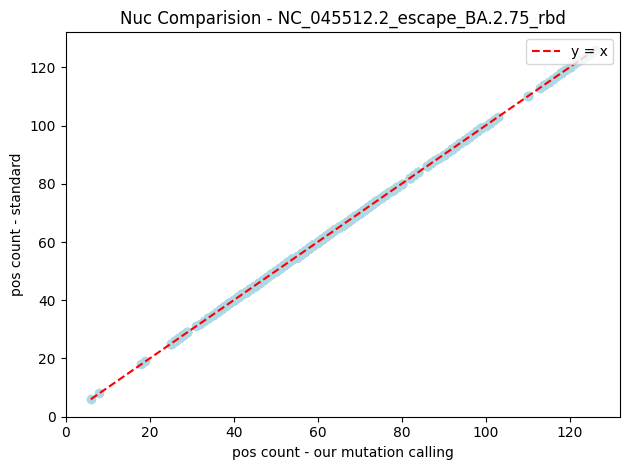

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


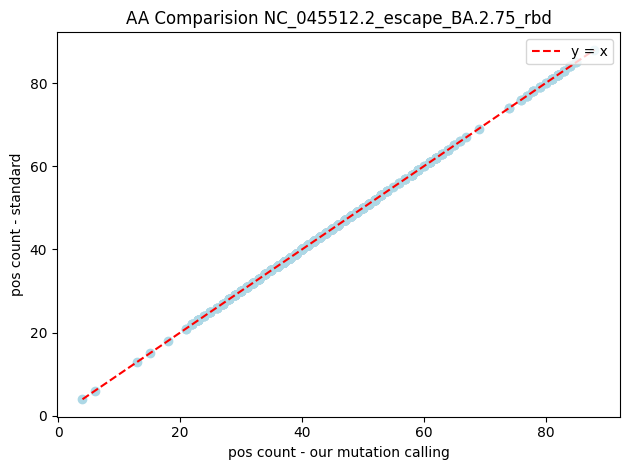

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
68715
68715


In [14]:
mut_a, mut_b, tmp1, tmp2 = compare(ba275_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.2.75_rbd")

NC_045512.2_escape_BA.4_BA.5_rbd
100.0 % identical in alignment.


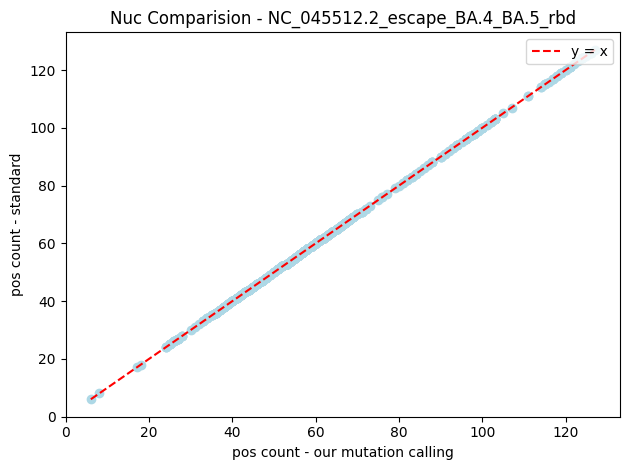

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


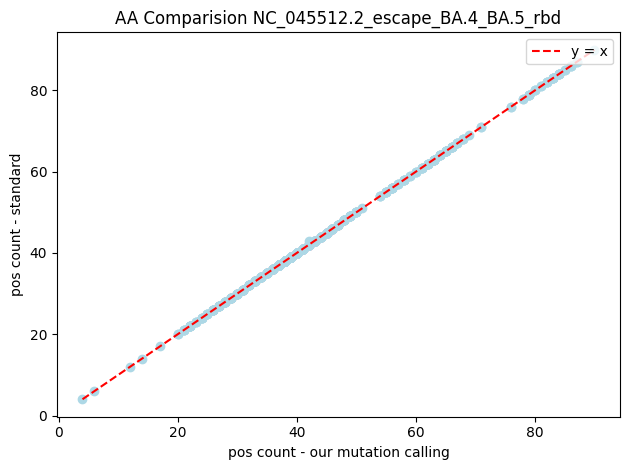

               sra  pos_count_standard  pos_count_manual  gap
666  SEARCH-102460                  43                42   -1
67455
67455


In [15]:
mut_a, mut_b, tmp1, tmp2 = compare(ba45_gf_dir, sc2_mm_dir, "NC_045512.2_escape_BA.4_BA.5_rbd")

NC_045512.2_escape_XBB.1.5_rbd
100.0 % identical in alignment.


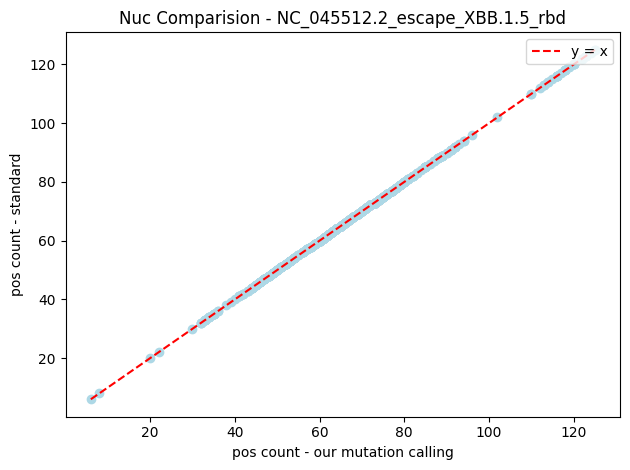

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


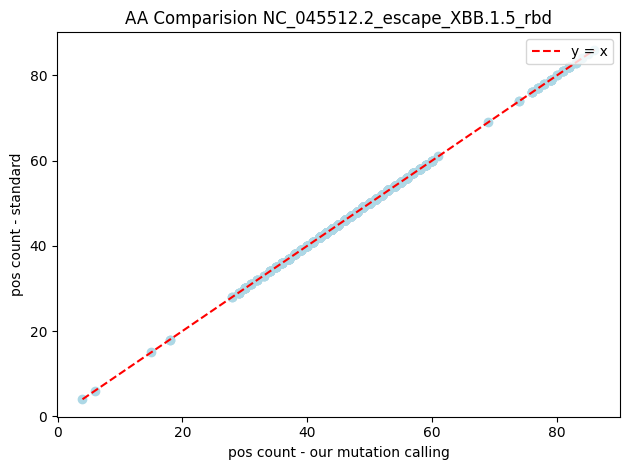

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
73762
73762


In [16]:
mut_a, mut_b, tmp1, tmp2 = compare(xbb_gf_dir, sc2_mm_dir, "NC_045512.2_escape_XBB.1.5_rbd")

NC_045512.2_escape_JN.1_rbd
94.0 % identical in alignment.


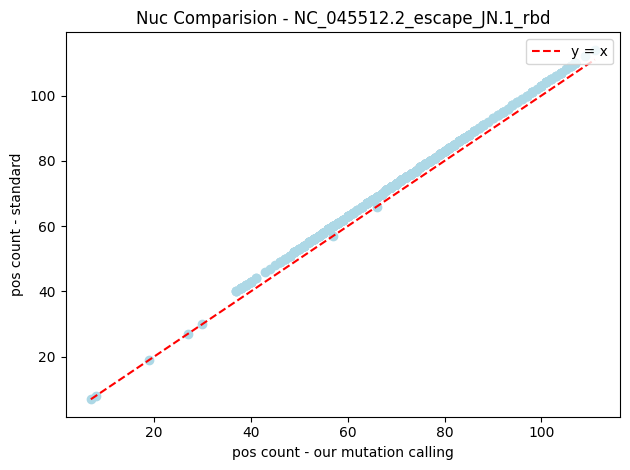

                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  82                79   -3
0             ALSR-1584                  41                38   -3
1             ALSR-1678                  40                37   -3
2         ATM-H48RA4QQ6                  76                73   -3
3         ATM-Q4EEY2D3N                  68                65   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  70                67   -3
26   CA-SDCPHL-91021350                  66                63   -3
27     CA-SEARCH-103136                  70                67   -3
28     CA-SEARCH-103152                  56                53   -3
29     CA-SEARCH-103471                  53                50   -3

[950 rows x 4 columns]


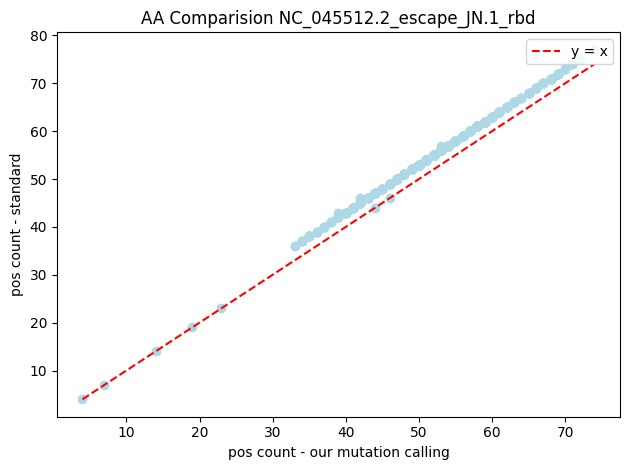

                  sra  pos_count_standard  pos_count_manual  gap
956     STM-ZMR4VFTFK                  55                52   -3
0           ALSR-1584                  37                34   -3
1           ALSR-1678                  38                35   -3
2       ATM-H48RA4QQ6                  60                57   -3
3       ATM-Q4EEY2D3N                  56                53   -3
..                ...                 ...               ...  ...
28   CA-SEARCH-103152                  46                43   -3
29   CA-SEARCH-103471                  45                42   -3
35   CA-SEARCH-103879                  46                42   -4
674      SEARCH-15574                  43                39   -4
628     SEARCH-102460                  57                53   -4

[950 rows x 4 columns]
77101
74251
Somthing wrong...


In [17]:
# there should be mismatch here since I manually modify nucs in reference genome to make it compatibale with gofasta
mut_a, mut_b, tmp1, tmp2 = compare(jn1_gf_dir, sc2_mm_dir, "NC_045512.2_escape_JN.1_rbd")

NC_045512.2_escape_KP.2_rbd
94.0 % identical in alignment.


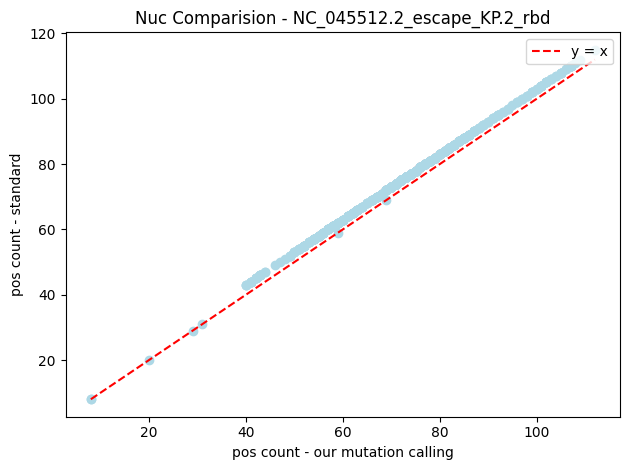

                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  85                82   -3
0             ALSR-1584                  44                41   -3
1             ALSR-1678                  43                40   -3
2         ATM-H48RA4QQ6                  79                76   -3
3         ATM-Q4EEY2D3N                  71                68   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  73                70   -3
26   CA-SDCPHL-91021350                  69                66   -3
27     CA-SEARCH-103136                  73                70   -3
28     CA-SEARCH-103152                  59                56   -3
29     CA-SEARCH-103471                  56                53   -3

[950 rows x 4 columns]


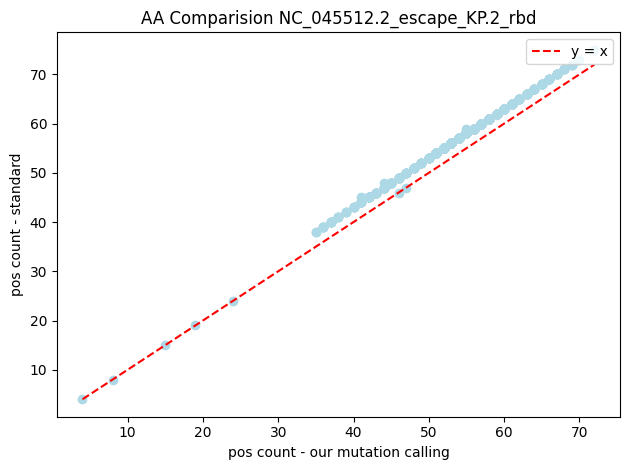

                  sra  pos_count_standard  pos_count_manual  gap
956     STM-ZMR4VFTFK                  57                54   -3
0           ALSR-1584                  39                36   -3
1           ALSR-1678                  40                37   -3
2       ATM-H48RA4QQ6                  62                59   -3
3       ATM-Q4EEY2D3N                  58                55   -3
..                ...                 ...               ...  ...
28   CA-SEARCH-103152                  48                45   -3
29   CA-SEARCH-103471                  47                44   -3
35   CA-SEARCH-103879                  48                44   -4
674      SEARCH-15574                  45                41   -4
628     SEARCH-102460                  59                55   -4

[950 rows x 4 columns]
79431
76581
Somthing wrong...


In [18]:
# there should be mismatch here since I manually modify nucs in reference genome to make it compatibale with gofasta
mut_a, mut_b, tmp1, tmp2 = compare(kp2_gf_dir, sc2_mm_dir, "NC_045512.2_escape_KP.2_rbd")

NC_045512.2_escape_KP.3_rbd
94.0 % identical in alignment.


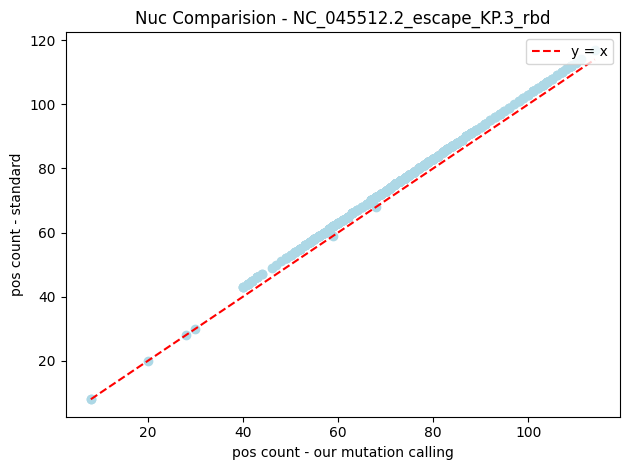

                    sra  pos_count_standard  pos_count_manual  gap
956       STM-ZMR4VFTFK                  85                82   -3
0             ALSR-1584                  44                41   -3
1             ALSR-1678                  43                40   -3
2         ATM-H48RA4QQ6                  79                76   -3
3         ATM-Q4EEY2D3N                  71                68   -3
..                  ...                 ...               ...  ...
25   CA-SDCPHL-82421030                  73                70   -3
26   CA-SDCPHL-91021350                  69                66   -3
27     CA-SEARCH-103136                  73                70   -3
28     CA-SEARCH-103152                  59                56   -3
29     CA-SEARCH-103471                  56                53   -3

[950 rows x 4 columns]


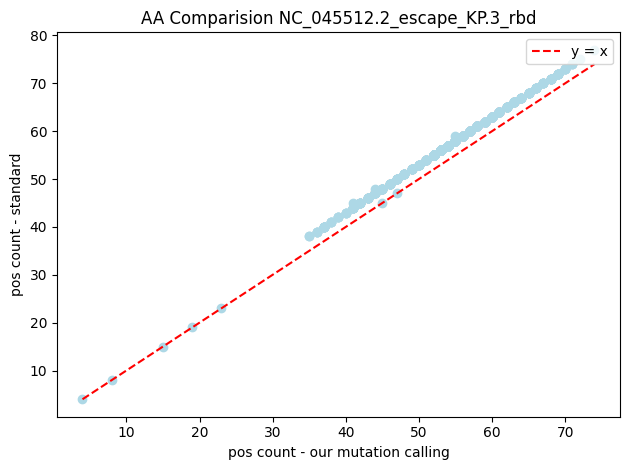

                  sra  pos_count_standard  pos_count_manual  gap
956     STM-ZMR4VFTFK                  57                54   -3
0           ALSR-1584                  39                36   -3
1           ALSR-1678                  40                37   -3
2       ATM-H48RA4QQ6                  62                59   -3
3       ATM-Q4EEY2D3N                  58                55   -3
..                ...                 ...               ...  ...
28   CA-SEARCH-103152                  48                45   -3
29   CA-SEARCH-103471                  47                44   -3
35   CA-SEARCH-103879                  48                44   -4
674      SEARCH-15574                  45                41   -4
628     SEARCH-102460                  59                55   -4

[950 rows x 4 columns]
79829
76979
Somthing wrong...


In [19]:
# there should be mismatch here since I manually modify nucs in reference genome to make it compatibale with gofasta
mut_a, mut_b, tmp1, tmp2 = compare(kp3_gf_dir, sc2_mm_dir, "NC_045512.2_escape_KP.3_rbd")

In [ ]:

'''
WITH tmp AS (
SELECT a.position_nt from mutations m
JOIN mutation_translations mt ON mt.mutation_id = m.id
JOIN amino_acids aa ON mt.amino_acid_id = aa.id
JOIN samples s ON m.sample_id = s.id
JOIN samples_lineages sl ON sl.sample_id = s.id
JOIN lineages l ON sl.lineage_id = l.id
JOIN alleles a ON a.id = m.allele_id
GROUP BY a.position_nt
HAVING COUNT(DISTINCT ref_nt) > 2
)

SELECT t.position_nt, a.ref_nt, a.alt_nt, s.accession, COUNT(*)
FROM mutations m 
JOIN alleles a ON m.allele_id = a.id
JOIN tmp t ON t.position_nt = a.position_nt
JOIN samples s ON s.id = m.sample_id
JOIN mutation_translations mt ON mt.mutation_id = m.id
JOIN amino_acids aa ON aa.id = mt.amino_acid_id
GROUP BY t.position_nt, a.ref_nt, a.alt_nt, s.accession
ORDER BY t.position_nt, a.ref_nt;
'''

In [ ]:
# calculate prevalence
# For a given lineage, its the number of samples that have a particular mutation at a site out of all the samples that belong to that lineage

# SQL query to export the prevalence from muninn
'''
\copy (
    WITH denom AS (
    SELECT
        sl.lineage_id,
        COUNT(DISTINCT sl.sample_id) AS n_in_lineage
    FROM samples_lineages sl
    GROUP BY sl.lineage_id
    )

    SELECT
    l.lineage_name,
    a.position_nt,
    ROUND(
        COUNT(DISTINCT m.sample_id)::numeric / d.n_in_lineage
    , 4) AS prevalence,
    COUNT(DISTINCT m.sample_id) AS n_with_mut_at_site,
    d.n_in_lineage
    FROM mutations m
    JOIN alleles a         ON a.id = m.allele_id
    JOIN samples_lineages sl ON sl.sample_id = m.sample_id
    JOIN lineages l        ON l.id = sl.lineage_id
    JOIN denom d           ON d.lineage_id = l.id
    GROUP BY l.id, l.lineage_name, a.position_nt, d.n_in_lineage
    ORDER BY l.lineage_name, a.position_nt
) TO 'prevalence.csv' WITH CSV HEADER;
'''

In [ ]:
'''
WITH denom AS (
SELECT
    sl.lineage_id,
    COUNT(DISTINCT sl.sample_id) AS n_in_lineage
FROM samples_lineages sl
GROUP BY sl.lineage_id
),
aa_sites AS (
SELECT DISTINCT
    aa.id, 
    sl.lineage_id,
    l.lineage_name,
    sl.sample_id, 
    (aa.ref_aa || aa.position_aa::text || aa.alt_aa) AS aa_site
FROM amino_acids aa
JOIN mutation_translations mt ON aa.id = mt.amino_acid_id
JOIN mutations m ON m.id = mt.mutation_id
JOIN samples_lineages sl ON m.sample_id = sl.sample_id
JOIN lineages l ON sl.lineage_id = l.id
)

SELECT
    aas.lineage_name,
    aas.aa_site,
    ROUND(COUNT(*)::numeric / d.n_in_lineage, 6) AS prevalence,
    COUNT(*) AS n_with_mut,
    d.n_in_lineage
FROM aa_sites aas
JOIN denom d ON d.lineage_id = aas.lineage_id
GROUP BY aas.lineage_id, aas.lineage_name, aas.aa_site, d.n_in_lineage
ORDER BY aas.lineage_name, aas.aa_site;
'''

In [ ]:
'''
WITH denom AS (
SELECT
    sl.lineage_id,
    l.lineage_name,
    COUNT(DISTINCT sl.sample_id) AS n_in_lineage
FROM samples_lineages sl
JOIN lineages l ON sl.lineage_id = l.id
GROUP BY sl.lineage_id, l.lineage_name
ORDER BY l.lineage_name
)

SELECT DISTINCT
    sl.lineage_id,
    l.lineage_name,
    (aa.ref_aa || aa.position_aa::text || aa.alt_aa) AS aa_site,
    COUNT(DISTINCT m.sample_id) AS n_mut,
    a.position_nt
FROM amino_acids aa
JOIN mutation_translations mt ON aa.id = mt.amino_acid_id
JOIN mutations m ON m.id = mt.mutation_id
JOIN alleles a ON a.id = m.allele_id
JOIN samples_lineages sl ON m.sample_id = sl.sample_id
JOIN lineages l ON sl.lineage_id = l.id
GROUP BY sl.lineage_id, l.lineage_name, aa.ref_aa, aa.position_aa, aa.alt_aa, a.position_nt
ORDER BY l.lineage_name;
'''

In [ ]:
'''
\copy (
    WITH denom AS (
    SELECT
        sl.lineage_id,
        l.lineage_name,
        COUNT(DISTINCT sl.sample_id) AS n_in_lineage
    FROM samples_lineages sl
    JOIN lineages l ON sl.lineage_id = l.id
    GROUP BY sl.lineage_id, l.lineage_name
    ORDER BY l.lineage_name
    ),
    amino_acid_sites AS (
    SELECT DISTINCT
        sl.lineage_id,
        l.lineage_name,
        (aa.ref_aa || aa.position_aa::text || aa.alt_aa) AS aa_site,
        COUNT(DISTINCT m.sample_id) AS n_mut,
        a.position_nt
    FROM amino_acids aa
    JOIN mutation_translations mt ON aa.id = mt.amino_acid_id
    JOIN mutations m ON m.id = mt.mutation_id
    JOIN alleles a ON a.id = m.allele_id
    JOIN samples_lineages sl ON m.sample_id = sl.sample_id
    JOIN lineages l ON sl.lineage_id = l.id
    GROUP BY sl.lineage_id, l.lineage_name, aa.ref_aa, aa.position_aa, aa.alt_aa, a.position_nt
    ORDER BY l.lineage_name
    )

    SELECT 
        aas.lineage_id,
        aas.lineage_name,
        aas.aa_site,
        aas.n_mut,
        d.n_in_lineage,
        aas.position_nt,
        aas.n_mut::numeric / d.n_in_lineage AS prevalence
    FROM amino_acid_sites aas
    JOIN denom d ON aas.lineage_name = d.lineage_name
) TO 'prevalence_aa.csv' WITH CSV HEADER;

'''

In [16]:
def heatmap(prevalence_path, lineage_ls, region="splike"):
    # 1-based idx
    SPIKE_COORDS = [21563, 25384]
    RBD_COORDS = [22553, 23155]
    region_coords = SPIKE_COORDS if region.lower() == "spike" else RBD_COORDS

    prevalence = pd.read_csv(prevalence_path)
    prevalence = prevalence[(region_coords[0] <= prevalence["position_nt"]) & (prevalence["position_nt"] <= region_coords[1]) & (prevalence["lineage_name"].isin(lineage_ls))]
    
    mat = prevalence.pivot_table(
        index="lineage_name",
        columns="position_nt",
        values="prevalence",
    )

    mat = mat.fillna(0)

    full_positions = np.arange(region_coords[0], region_coords[1] + 1, dtype=int)
    mat = mat.reindex(columns=full_positions).fillna(0.0)

    nrows, ncols = mat.shape
    w = max(10, min(28, 0.03 * ncols))
    h = max(3, 0.6 * nrows + 1.5)

    fig, ax = plt.subplots(figsize=(w, h))
    im = ax.imshow(mat.to_numpy(), aspect="auto", interpolation="nearest", cmap="RdBu_r")

    # ---- Y axis: lineage names
    ax.set_yticks(np.arange(nrows))
    ax.set_yticklabels(mat.index)

    # ---- X axis: show label every 10 bp (EXACT)
    wanted = np.arange((region_coords[0] // 10) * 10, region_coords[-1] + 1, 10, dtype=int)
    wanted = wanted[(wanted >= region_coords[0]) & (wanted <= region_coords[-1])]
    tick_idx = wanted - region_coords[0]  

    ax.xaxis.set_major_locator(FixedLocator(tick_idx))
    ax.xaxis.set_major_formatter(FixedFormatter([str(x) for x in wanted]))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", fontsize=6)

    ax.set_xlabel("position")
    ax.set_ylabel("lineages")

    # ---- Grid inside heatmap (cell boundaries)
    ax.set_xticks(np.arange(-0.5, ncols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, nrows, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.25, alpha=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    fig.colorbar(im, ax=ax, label="prevalence")
    fig.tight_layout()


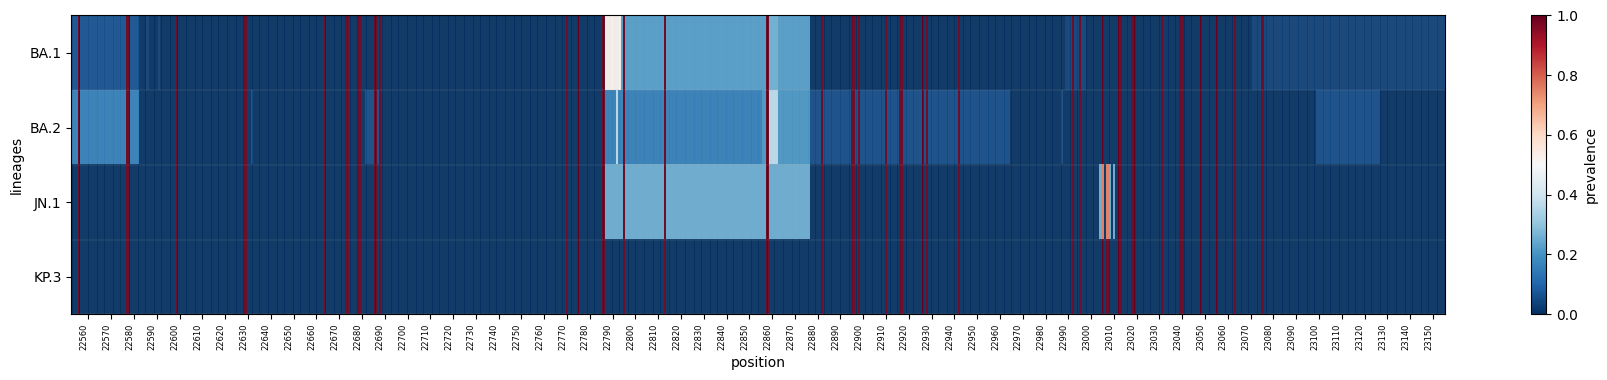

In [41]:
heatmap("/home/yutianc/muninn/prevalence.csv", ['BA.1', 'BA.2', 'KP.3', 'JN.1'])

In [ ]:
lineage = "BA.1"
df = pd.read_csv("/home/yutianc/muninn/prevalence.csv")
df = df[df['lineage_name'] == lineage]
df[df["n_with_mut_at_site"]<=1]

,lineage_name,position_nt,prevalence,n_with_mut_at_site,n_in_lineage
761,BA.1,190,0.0323,1,31
1390,BA.1,300,0.0323,1,31
6651,BA.1,1594,0.0323,1,31
6970,BA.1,1721,0.0323,1,31
6984,BA.1,1722,0.0323,1,31
...,...,...,...,...,...
171794,BA.1,29297,0.0323,1,31
171800,BA.1,29298,0.0323,1,31
171806,BA.1,29299,0.0323,1,31
171812,BA.1,29300,0.0323,1,31


In [48]:
def _aa_pos(aa_site: str): 
    m = re.search(r"(\d+)", str(aa_site)) 
    return int(m.group(1)) if m else None

def aa_heatmap(aa_prevalence_path, lineage_ls, threshold, region="spike"):
    SPIKE_COORDS = [21563, 25384]
    RBD_COORDS = [22553, 23155]
    region_coords = SPIKE_COORDS if region.lower() == "spike" else RBD_COORDS

    df = pd.read_csv(aa_prevalence_path)
    mat = (
        df[(df["lineage_name"].isin(lineage_ls))
           & (df["prevalence"] >= threshold)
           & (region_coords[0] <= df["position_nt"])
           & (df["position_nt"] <= region_coords[1])]
        .pivot_table(index="lineage_name", columns="aa_site", values="prevalence", aggfunc="max")
        .reindex(lineage_ls)
    )

    cols_sorted = sorted(mat.columns, key=lambda s: (_aa_pos(s) if _aa_pos(s) is not None else 10**9, str(s)))
    mat = mat.reindex(columns=cols_sorted)

    data = mat.to_numpy(dtype=float)
    data[data < threshold] = np.nan 

    # colormap with NaNs in white
    cmap = mpl.cm.get_cmap("RdPu").copy()
    cmap.set_bad("#BDBDBD")

    nrows, ncols = data.shape
    fig, ax = plt.subplots(figsize=(20, 6))

    # pcolormesh expects cell edges; centers are at i+0.5
    x = np.arange(ncols + 1)
    y = np.arange(nrows + 1)

    norm = mpl.colors.Normalize(vmin=threshold, vmax=1, clip=True)
    mesh = ax.pcolormesh(
        x, y, data,
        cmap=cmap,                 
        norm=norm,
        shading="flat",
        edgecolors="white",
        linewidth=0.8
    )

    # y-axis
    ax.set_yticks(np.arange(nrows) + 0.5)
    ax.set_yticklabels(mat.index)
    ax.invert_yaxis()

    # x-axis (ONE place only)
    show_every_n_xlabels = 1
    tick_pos = np.arange(ncols) + 0.5
    labels = mat.columns.astype(str).tolist()
    if show_every_n_xlabels > 1:
        labels = [lab if (i % show_every_n_xlabels == 0) else "" for i, lab in enumerate(labels)]

    ax.set_xticks(tick_pos)
    ax.set_xticklabels(labels, rotation=60, ha="center", va="top", fontsize=8)
    ax.tick_params(axis="x", pad=2)

    # tight extent to mesh
    ax.set_xlim(0, ncols)
    ax.set_ylim(nrows, 0)

    ax.set_facecolor("white")
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    # top colorbar
    cax = fig.add_axes([0.12, 0.84, 0.55, 0.05])
    cb = fig.colorbar(mesh, cax=cax, orientation="horizontal")
    cb.set_label("val", labelpad=-28, x=-0.06, rotation=0)
    cb.set_ticks(np.linspace(threshold, 1, 6))

    nan_patch = mpl.patches.Patch(color="#BDBDBD", label=f"< {threshold} or missing")
    ax.legend(handles=[nan_patch], loc="upper left", bbox_to_anchor=(1.005, 1.02),
              frameon=False, borderaxespad=0.0)
    
    plt.subplots_adjust(top=0.78, bottom=0.22, left=0.18, right=0.98)
    
    return fig, ax, data


/tmp/ipykernel_2538744/297814148.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("RdPu").copy()


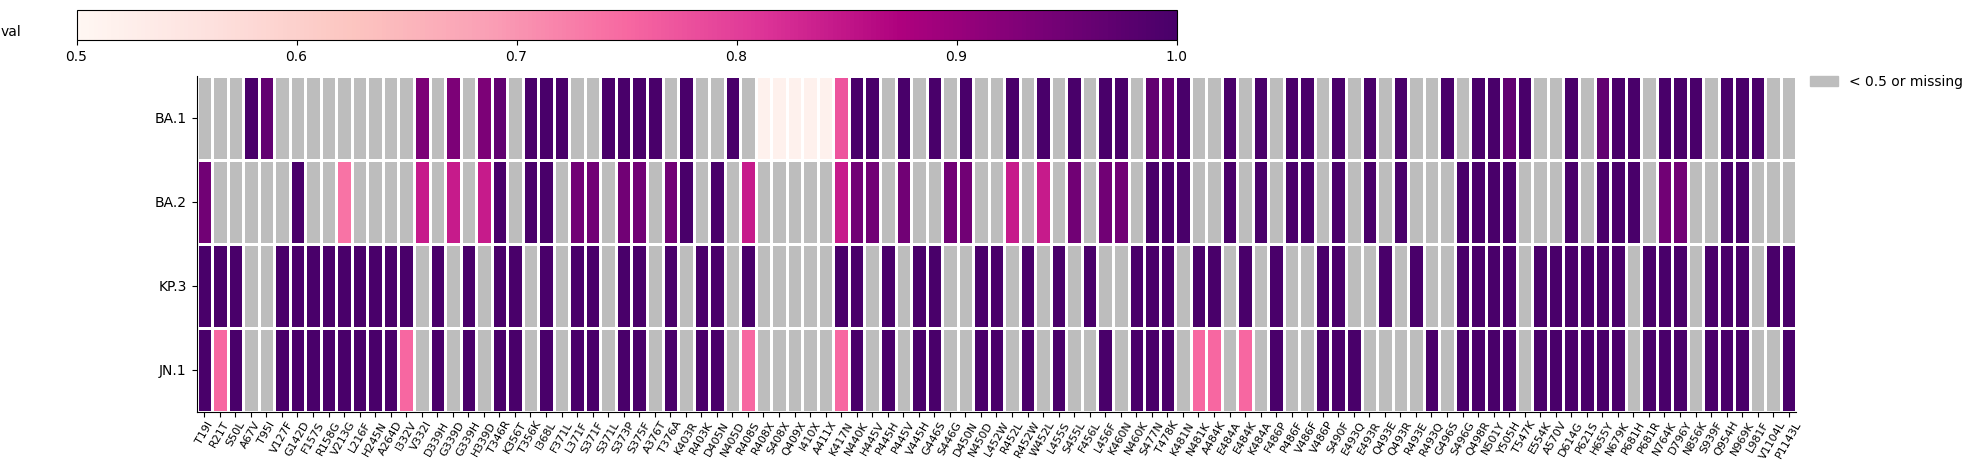

In [49]:
fig, ax, data = aa_heatmap("/home/yutianc/muninn/prevalence_aa.csv", ['BA.1', 'BA.2', 'KP.3', 'JN.1'], 0.5, "spike")

In [29]:
data

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 1.

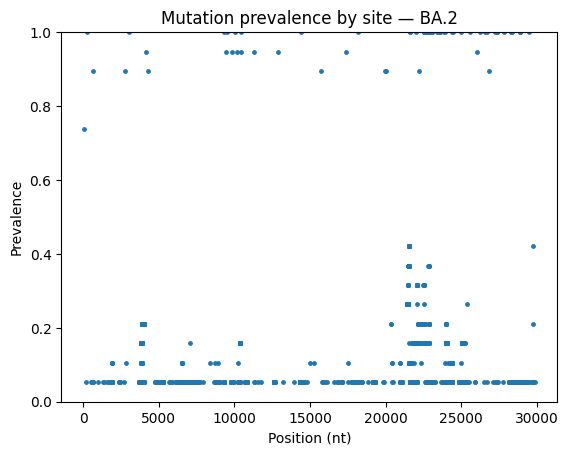

In [10]:
lineage = "BA.2"
df = p[p['lineage_name'] == lineage].copy()
df = df.dropna(subset=["position_nt", "prevalence"]).sort_values("position_nt")

plt.figure()
plt.scatter(df["position_nt"], df["prevalence"], s=6)
plt.xlabel("Position (nt)")
plt.ylabel("Prevalence")
plt.title(f"Mutation prevalence by site — {lineage}")
plt.ylim(0, 1)
plt.show()